# Graph Analysis of Last.FM data.

Graph analysis is performed in an attempt to better understand the listening habitats of the Last.FM users. Three undirected graphs $G(N, E)$ are constructed that consists of a finite set of nodes $N$ and a finite set of edges $E$. With each edge E of G, there will be an associated real number $w(E)$, called its weight. 

*Graph_1* takes advantage of the present $friend \longleftrightarrow friend$ relationships detailed in the data. As this is a friendship relationship rather than a follow relationships, the graph is undirected.  In this case,  $W(E)= 1 $


Currently, there is  $ user \longleftrightarrow  artist $  relationships present in the data. In order to analyse this occurrence, we project this bipartite area of 
interest into a monopartite sub-graph. *Graph_2* contains $ user \longleftrightarrow  user $ edges where $w(E)= CA$ 

where $CA$ is the number of common artists between users. 

As is evident so far in this investigation, the are a large number of tags (11946)  and these user-submitted semantic categories often contain overlap or are junk. We construct *Graph_3* in attempt to find "super tags" i.e. novel tags that effectively covers numerous sub-tags in an attempt to remove redundancy. We believe this may also improve Last.fm's recommendation system if these novel tags were part  of the system.  *Graph_3*  contains $tag \longleftrightarrow tag$ relationships where $w(E)$= number of common artists. If two tags have no overlapping artists, there exists no relationship.  

## Table of Contents
- [Importing libraries and data files](#importing-libraries-and-data-files)
- [Construct Graphs](#constructing-the-graphs)
- [Degree centrality](#degree-centrality)
- [Local clustering coefficient](#clustering-coefficient-and-triangular-count)
- [Betweenness centrality](#betweeness-centrality)
- [Louvian Modularity](#Louvian-modularity)
- [Label propagation (Finding Super Tags)](#label-propagation)

In this investigation, all the graph algorithms described above besides Label propagation are performed on *Graph_1* and *Graph_2*. We will only use Label propagation on *Graph_3*

## Importing libraries and Data files


In [282]:
import networkx as nx
from collections import defaultdict
import os
import itertools
import seaborn as sns
import collections
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import ast
! pip install python-louvain
import community as cp
import community as community_louvain

In [283]:
#from google.colab import drive
#drive.mount('/content/drive/')
#os.chdir("/content/drive/My Drive/DCU/fouth_year/advanced_machine_learning/assignment-3/music-recommodation-system")

In [284]:
user_artists = pd.read_csv('data/user_artists.dat', sep='\t')
user_friendships =  pd.read_csv('data/unqiue_friendships.csv')
tags = pd.read_csv(open('data/tags.dat', errors='replace'), sep='\t')
user_taggedartists = pd.read_csv(r'data/user_taggedartists-timestamps.dat', sep='\t')
user_taggedartists = pd.merge(user_taggedartists, tags, on=['tagID'])
tags = pd.read_csv(open('data/tags.dat', errors='replace'), sep='\t')



## Constructing the graphs
In order to construct the graphs, we must further construct  a list of vertices and a list of tuples detailing edges in a particular graph.  We use the *Graph* object as we want an undirected graph. Note, calculating the edges and vertices for *Graph_2* and *Graph_3* wil take several hours. Jupyter book raises a run time exception in this scenario. Therefore, we decide to pre-compute the required edges and vertices and save them into csv files. The code required to construct these graphs is provided for verification purposes. 

In [285]:
graph_1 = nx.Graph()
graph_2 = nx.Graph()
graph_3 = nx.Graph()

In [286]:

# GRAPH 1 

# graph_1_vertcies = list(set(user_friendships['friend1_id'].values).union(set(user_friendships['friend2_id'].values)))
# graph_1_edges = list()
# for index, row in user_friendships.iterrows():
#   graph_1_edges.append((row['friend1_id'], row['friend2_id']))

# GRAPH 2
# pairs_users = list(itertools.combinations(user_artists['userID'].unique(), 2))
# graph_2_vertices = set()
# graph_2_edges = []
# for user_1,user_2 in pairs_users:
#   user_1_artists = set(user_artists[user_artists['userID'] == user_1]['artistID'].values)
#   user_2_artists = set(user_artists[user_artists['userID'] == user_2]['artistID'].values)
#   common_artist_count = len(user_1_artists.intersection(user_2_artists))
#   if common_artist_count > 0:
#     graph_2_vertices.add(user_1)
#     graph_2_vertices.add(user_2)
#     graph_2_edges.append((user_1, user_2, {'weight': common_artist_count}))

# GRAPH 3
# pair_tags = list(itertools.combinations(user_taggedartists['tagValue'].unique(), 2))
# graph_3_vertices = set()
# graph_3_edges = []
# for tag_1,tag_2 in pair_tags:
#   tag_1_artists = set(user_taggedartists[user_taggedartists['tagValue'] == tag_1]['artistID'].values)
#   tag_2_artists = set(user_taggedartists[user_taggedartists['ustagValueerID'] == tag_1]['artistID'].values)
#   common_artist_count = len(tag_1_artists.intersection(tag_2_artists))
#   if common_artist_count > 0:
#     graph_3_vertices.add(tag_1)
#     graph_3_vertices.add(tag_2)
#     graph_3_edges.append((tag_1, tag_2, {'weight': common_artist_count}))

In [287]:
def convert_df_list_tuples(df, weight=True):
    """Converts edge df columns to a list of tuples"""
    edges = list()
    if not weight:
        for index, row in df.iterrows():
            edges.append((row[0], row[1], {'weight':1}))
    else:
        for index, row in df.iterrows():
            edges.append((row[0], row[1], ast.literal_eval(row[2])))
    return edges


In [288]:

graph_1_vertcies =  pd.read_csv('data/graph/graph_1_vertices.csv')['friends'].values.tolist()
graph_1_edges =  pd.read_csv('data/graph/graph_1_edges.csv')
graph_1_edges = convert_df_list_tuples(graph_1_edges, False)

graph_2_vertices =  pd.read_csv('data/graph/graph_2_vertices.csv')['users'].values.tolist()
graph_2_edges =  pd.read_csv('data/graph/graph_2_edges.csv')
graph_2_edges = convert_df_list_tuples(graph_2_edges, True)

graph_3_vertices =  pd.read_csv('data/graph/graph_3_vertices.csv')['tags'].values.tolist()
graph_3_edges =  pd.read_csv('data/graph/graph_3_edges.csv')
graph_3_edges = convert_df_list_tuples(graph_3_edges, True)

In [289]:
graph_1.add_nodes_from(graph_1_vertcies)
graph_1.add_edges_from(graph_1_edges)

graph_2.add_nodes_from(graph_2_vertices)
graph_2.add_edges_from(graph_2_edges)

graph_3.add_nodes_from(graph_3_vertices)
graph_3.add_edges_from(graph_3_edges)

In [290]:
## Validation checks of the graphs. 
assert len(graph_1_vertcies) == len(graph_1.nodes())
assert len(graph_1_edges) == len(graph_1.edges())
assert graph_1.get_edge_data(2, 4) == None

assert len(graph_2_vertices) == len(graph_2.nodes())
assert len(graph_2_edges) == len(graph_2.edges())
assert graph_2.get_edge_data(2, 4) == {'weight': 7}


assert len(graph_3_edges) == len(graph_3.edges())
assert len(graph_3_vertices) == len(graph_3.nodes())
assert graph_3.get_edge_data('chillout', 'downtempo') == {'weight': 263}

## Degree centrality 
Our initial graphs analysis is very simple. We compute the amount of degrees each nodes has in *Graph_1* and *Graph_2*. The degree is the number of links incident upon a node. The nodes are then sorted by degree descending to find the users that have the most number of friends in *Graph_1* and the users who listen to the most artists in *Graph_2*. 

In [291]:
def get_five(dictionary, algo_string):
    count = 0
    user_id  = []
    values = []
    for user, value in dictionary.items():
        user_id.append(user)
        values.append(value)
        if count == 4:
            break
        count+=1
    return pd.DataFrame(data={"userID":user_id,algo_string:values})

*Graph_1*: The top five users with the most number of friends

In [292]:
get_five(dict(sorted(nx.algorithms.centrality.degree_centrality(graph_1).items(), key=lambda item: item[1], reverse=True)), "Degree Centrality")

,userID,Degree Centrality
0,1543,0.062930
1,1281,0.058170
2,831,0.056055
3,179,0.051296
4,1503,0.050238


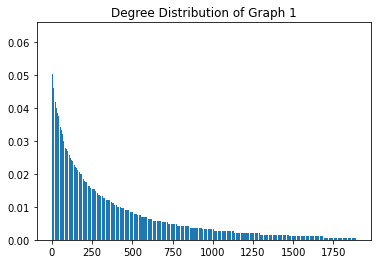

In [293]:
dc = nx.degree_centrality(graph_1)
degrees = dc.values()
degrees = sorted(degrees, reverse=True)
plt.bar(range(len(degrees)), degrees, align='center')
plt.title('Degree Distribution of Graph 1')
plt.show()

The above figure plots the degree centrality distribution of *graph_1*. As expected, the distribution histogram of degree centrality has a long tail, which means their are few people have a lot of friends while most of people have a relatively small number of friends.

*Graph_2*: The top five users who have listened to the most amount of artists.

In [294]:
get_five(dict(sorted(nx.algorithms.centrality.degree_centrality(graph_2).items(), key=lambda item: item[1], reverse=True)), "Degree Centrality")

,userID,Degree Centrality
0,1368,0.909766
1,458,0.904989
2,1469,0.898620
3,864,0.890127
4,1114,0.885350


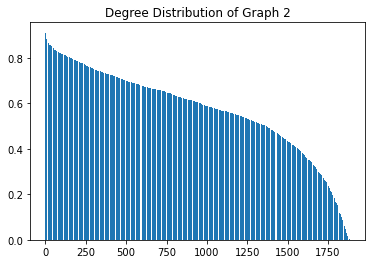

In [295]:
dc = nx.degree_centrality(graph_2)
degrees = dc.values()
degrees = sorted(degrees, reverse=True)
plt.bar(range(len(degrees)), degrees, align='center')
plt.title('Degree Distribution of Graph 2')
plt.show()

Again, the above plot describes the degree centrality distribution of *graph_2*.  The distribution is only slightly right skewed. This indicates that the userbase of Last.fm generally listens to a limited number of artists with a significant number also listening to a wide range of artists. 

## Clustering coefficient and triangular count

Triangular count refers to the number of triangles or 3-clique for each node in a graph. A triangle is a set of three nodes where each node has a relationship to the other two. Triangular count is particularly useful in social media analysis where it is used to detect communities and graph cohesiveness. It also used as part is used as part of the local clustering coefficient algorithm ($C_{n}$) of a node n. . This algorithm describes the likelihood ([0,1]) that n's neighbour's  are also connected. **Note**, this algorithm is computed for each node. For unweighted graphs like *graph_1*, 
$
C_{n} = \frac{2T_{n}}{d_{n}(d_{n}) - 1}
$
where $T_{n}$ is the number of triangles that node n is part of, and $d_{n}$ is the degree of node n. 

For weighted graphs like *Graph_2*, there are several ways to define clustering ([Saramäki et al, 2007](https://link.aps.org/pdf/10.1103/PhysRevE.75.027105)). Networkx's uses the geometric average of the subgraph edge weights, that is 
$
C_{n} = \frac{1}{d_{n}(d_{n}) - 1} \sum_{vw}{} (\hat{w}_{uv}\hat{w}_{uw}\hat{w}_{vw})^{\frac{1}{3}}
$
The edge weights $\hat{w}_{uv}$ are normalized by dividing by the maximum weight in the network.
$
\hat{w}_{uv} = \frac{w_{uv}}{max(w)}
$
Note, if $d_{n}$ < 2, it is assigned a value of 0. 

To measure the global cohesiveness of a graph, we can calculate the average local clustering coefficient from all nodes. Due to the quite large graphs, we will just display the output and comment out the code. Otherwise, we run into timeout errors when trying to build the jupyter book. 

In [296]:
#networkx.algorithms.cluster.average_clustering(graph_1)

0.18654479547922215

In [297]:
#networkx.algorithms.cluster.average_clustering(graph_2, weight='weight')

0.06315564340785443

Globally, the graph_1 projection has an average clustering coefficient of 0.186544. This indicates, on average, a user's friends have a probability of 18.6% of also being friends. This indicates that the social network of Last.fm is not tight knit together but rather sparse. A network with a higher average clustering coefficient is often called a small world network, which this graph does not show.

Similarly, the graph_2 projection has an average clustering coefficient of 0.0631556. This indicates that the music taste of Last.fm's users are rather sparse, with each artist's audience being unlikely to listen to the same artist.

## Betweenness Centrality

Betweenness centrality detects the amount of influence a node has over the flow of information in a graph i.e. detecting
‘bridge points’ between one part of a graph to another. For *graph_1,* we interrupt these bridging nodes as famous Djs
or prominent influencers within the graph. For *graph_2*, we interpret these bridging nodes as people with varied music
tastes, joining users with almost mono music interests

*Graph_1*: The most influential users of Last.FM

In [298]:
get_five(dict(sorted(nx.algorithms.centrality.betweenness_centrality(graph_1).items(), key=lambda item: item[1], reverse=True)), "Degree Centrality")

,userID,Degree Centrality
0,1543,0.066527
1,1281,0.054549
2,831,0.048691
3,1258,0.043025
4,78,0.029337


*Graph_2*: Users who listen to the most diverse set of artists 

In [299]:
get_five(dict(sorted(nx.algorithms.centrality.betweenness_centrality(graph_2).items(), key=lambda item: item[1], reverse=True)), "Degree Centrality")

,userID,Degree Centrality
0,1989,0.001067
1,240,0.000911
2,1914,0.000769
3,458,0.000761
4,1368,0.000743


## Louvain modularity:

Louvain modularity is not part of the official networkx library. Therefore, we decide to use the python-louvian
package. Louvain modularity is used to find communities, hierarchies and/or evaluate different grouping thresholds.
Louvain modularity compares relationship densities in given clusters to densities between clusters i.e. we want a lot of
connections in the set and few connections outside the set. We apply this algorithm to *Graph_1* and *Graph_2* to find:

- (a) distinct social communities
- (b) distinct communities of similar music tastes

We relate (b) to the tags, in an effort to see if there is a correlation between the implicit data of artist listenership vs the explicit data of user-submitted tags.  

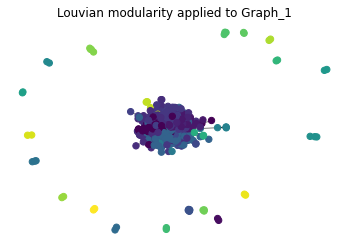

In [300]:
partition = community_louvain.best_partition(graph_1)
# draw the graph_1
pos = nx.spring_layout(graph_1)

cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph_1, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph_1, pos, alpha=0.5)
plt.title('Louvian modularity applied to Graph_1')
plt.axis('off')
plt.show()

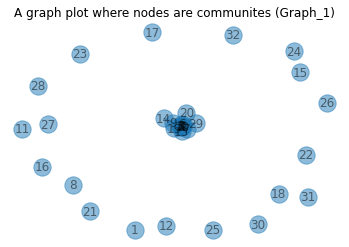

In [301]:

IG = community_louvain.induced_graph(partition, graph_1)
pos = nx.spring_layout(IG)
plt.title('A graph plot where nodes are communites (Graph_1)')
nx.draw_networkx(IG, pos, alpha=.5)
plt.axis('off')
plt.show()

In [302]:
print(f'Louvian modularity identifies { max(partition.values()) + 1} communities in the social network graph')

Louvian modularity identifies 33 communities in the social network graph


In [303]:
print('Modularity score for the partition:', community_louvain.modularity(partition, graph_1))

Modularity score for the partition: 0.45093205542255865


The modularity score is a measure of the structure of the graph. Graphs with high modularity scores have many connections within a community but only few pointing outwards to other communities where as the opposite is true for the inverse result. Modularity score lies between [-0.5, 1), so the final modularity score for the partition is pretty high, indicating that these number of communities is reasonably accurate.

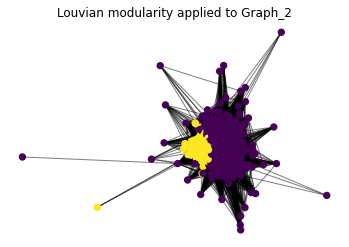

In [304]:
partition = community_louvain.best_partition(graph_2, weight='weight')
# draw the graph_2
pos = nx.spring_layout(graph_2)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph_2, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()))
plt.title('Louvian modularity applied to Graph_2')
nx.draw_networkx_edges(graph_2, pos, alpha=0.5)
plt.axis('off')
plt.show()

In [305]:
print(f'Louvian modularity identifies { max(partition.values()) + 1} communities in  graph 2')


Louvian modularity identifies 2 communities in  graph 2


In [306]:
print('Modularity score for the partition :', community_louvain.modularity(parts, graph_2))

Modularity score for the partition : 0.28234715583451236


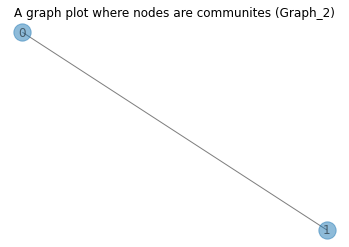

In [307]:
IG = community_louvain.induced_graph(partition, graph_2, weight='weight')
plt.title('A graph plot where nodes are communites (Graph_2)')
pos = nx.spring_layout(IG)
nx.draw_networkx(IG, pos, alpha=.5)
plt.axis('off')
plt.show()


These form during the algorithms second pass where several of the possible intuitive communities are merged together. Louvian modulairty has the power to  reveal hierarchy of communities at different scales. The function `generate_dendrogram` gives us a dictionary mapping from level of hierarchy to the partition. Finally, `partition_at_level` takes the result of `generate_dendrogram` and returns a dictionary of the partition, where keys are nodes and values are the index of partition the node belongs to. We use to find the level with the most number of communities. 


In [308]:
dendrogram = community_louvain.generate_dendrogram(graph_2, weight='weight')
parts = community_louvain.partition_at_level(dendrogram, len(dendrogram) - 1) # get the largest possible communities
values = [parts.get(node) for node in graph_2.nodes()]
spring_pos = nx.spring_layout(graph_2)
print('Community Node Distribution(Hierarchical Clustering):', collections.Counter(values))

Community Node Distribution(Hierarchical Clustering): Counter({0: 1097, 1: 589, 2: 199})


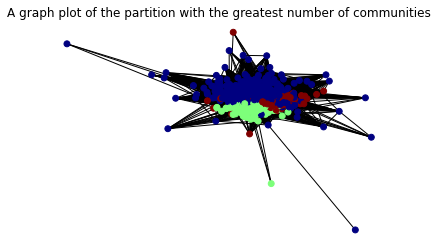

In [309]:
plt.title('A graph plot of the partition with the greatest number of communities')
plt.axis('off')
nx.draw_networkx(graph_2, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

Unfortunately, only a marginal number of additional communities were revealed when we reviewed the different levels of partitions. Finally, the top ten tags by occurrence are plotted in these communities. 

In [310]:
community_user_id_dict =  defaultdict(list)
for node_id, community in parts.items():
    community_user_id_dict[community].append(node_id)


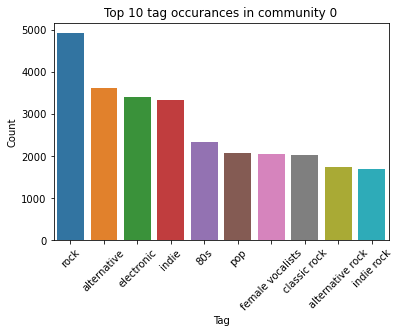

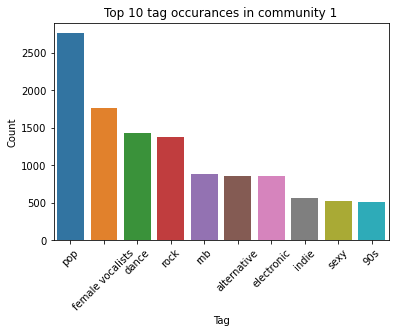

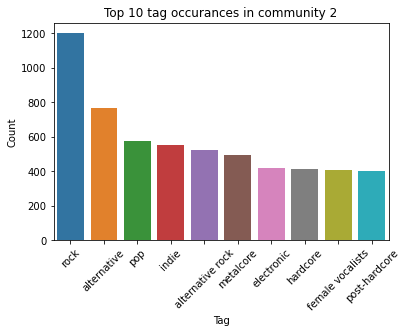

In [311]:
for community_number in community_user_id_dict:
    tag_list = user_taggedartists[user_taggedartists.userID.isin(community_user_id_dict[community_number])]['tagValue'].values.tolist()
    tag_occurances =  collections.Counter(tag_list).most_common(10)
    tag_df = pd.DataFrame.from_dict(tag_occurances)
    tag_df.columns =['Tag','Count']
    sns.barplot(x="Tag", y="Count", data=tag_df)
    plt.title(f'Top 10 tag occurances in community {community_number}')
    plt.xticks(rotation=45)
    plt.show()

We observe some commonality in these three communities. For instance, rock, electronic, pop, alternative were present in the top 10 assigned tags in all three communities. Although these are also the top four global tags. We expect this given the small number of communities identified. 


```{Reminder}
The weight attribute in Graph 2 represents the number of common artists in  user-user relationship. 
```


Besides this, we observe a clear distinction in music tastes among the three clusters. Cluster 0 has a more of tendency to listen to rock and sub genres of rock where as community 1 listens to 90s and dance music. Community 2 seems to follow the mainstream, with little defining music taste.

## Label Propagation - finding super tags

Similar to Louvian Modulaity, Label Propagation is used to find communities within a graph.  After initializing each node with a unique label, the algorithm repeatedly sets the label of a node to be the label that appears most frequently among that nodes neighbors. The algorithm halts when each node has the label that appears most frequently among its neighbors. From this notation of 'projected labeling', spun out the idea of creating "super tags" in an effort to reduce redundancy. We envision that these novel tags could be incorporated into Last.fMs retrieval or recommendation systems. This algorithm is applied to *graph_3*. 


In [316]:
c = list(nx.algorithms.community.label_propagation.label_propagation_communities(graph_3))
clusters = ([list(x) for x in c])
for cluster in clusters:
    if len(cluster) < 8:
        print(cluster)

['jaebeom', 'park jaebum', 'park jaebeom', 'jaebum', 'jaywalkers']
['kwasa', 'angola', 'semba']
['underground hip hp', 'luso hip hop', 'hip hop under', 'raptuga', 'hip hop angolano']


When these clusters were examined, we found some intuitive examples. For example, the tags 'underground hip hop','luso hip hop', 'hip hop under', 'raptuga', and 'hip hop angolano' being clustered together. They are all sub-groups of hip-hop. The tags 'kwasa', 'angola', 'semba' are all types of traditional   music, originating from central and south-western Africa. Finally, the first clustering group's tags all relate to the Korean-American rapper Jay Park. This example demonstrates our overall goal of removing redundancy. 